In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import sys 
sys.path.append('../training')
import pickle

from save_data import process_data

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configure

In [3]:
#DATASET_DATE = 00000000 # original dataset
#DATASET_DATE = 20240501
#DATASET_DATE = 20240527
DATASET_DATE = 20240528

# START_WINDOW = 285
# END_WINDOW = 385

# START_WINDOW = 150
# END_WINDOW = 350

START_WINDOW = 100
END_WINDOW = START_WINDOW + 400

# START_WINDOW = 25
# END_WINDOW = 745

# START_WINDOW = 5
# END_WINDOW = 765

# START_WINDOW = 1
# END_WINDOW = 769

#START_WINDOW = 0
#END_WINDOW = 770

### Enable/disable training

In [4]:
TRAIN = True

## Setup data

In [5]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [6]:
!mkdir -p models

DATA_DIR = f'../data/qick_data/{DATASET_DATE}/{str(START_WINDOW).zfill(3)}_{str(END_WINDOW).zfill(3)}'
MODEL_DIR = f'models/{DATASET_DATE}/model_{START_WINDOW}_{END_WINDOW}'

# convert raw ADC data into npy files 
if os.path.exists(f'{DATA_DIR}/X_train_{START_WINDOW}_{END_WINDOW}.npy') == False:
    print(f'ERROR: Missing file: {DATA_DIR}/X_train_{START_WINDOW}_{END_WINDOW}.npy')
    #process_data(
    #    start_window=START_WINDOW, 
    #    end_window=END_WINDOW, 
    #    data_dir=DATA_DIR
    #)

In [7]:
# load data
X_train_val = np.load(os.path.join(DATA_DIR, f'X_train_{START_WINDOW}_{END_WINDOW}.npy'))
X_test = np.load(os.path.join(DATA_DIR, f'X_test_{START_WINDOW}_{END_WINDOW}.npy'))    
y_train_val = np.load(os.path.join(DATA_DIR, f'y_train_{START_WINDOW}_{END_WINDOW}.npy'))
y_test = np.load(os.path.join(DATA_DIR, f'y_test_{START_WINDOW}_{END_WINDOW}.npy'))

y_train_val = one_hot_encode(y_train_val)
y_test = one_hot_encode(y_test)

print('Window:')
print('  - Couples I/Q :', (END_WINDOW-START_WINDOW))
print('  - Model inputs:', (END_WINDOW-START_WINDOW)*2)

print('Training:')
print('  - Size        :', X_train_val.shape[0])
print('  - Sample Shape:', X_train_val.shape[1])
print('  - Mean        :', X_train_val.mean())
print('  - Std. Dev.   :', X_train_val.std())

print('Testing:')
print('  - Size        :', X_test.shape[0])
print('  - Sample Shape:', X_test.shape[1])
print('  - Mean        :', X_test.mean())
print('  - Std. Dev.   :', X_test.std())

assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, 'ERROR: Specified window does not match loaded dataset shape'

Window:
  - Couples I/Q : 400
  - Model inputs: 800
Training:
  - Size        : 900000
  - Sample Shape: 800
  - Mean        : 42.473523191666665
  - Std. Dev.   : 842.7678298796162
Testing:
  - Size        : 100000
  - Sample Shape: 800
  - Mean        : 42.5891728375
  - Std. Dev.   : 844.2103580495092


## Construct a model 
QKeras is 'Quantized Keras' for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [8]:
INIT_LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 12800
EPOCHS = 50
CHECKPOINT_FILENAME = MODEL_DIR + f'/qmodel_{START_WINDOW}_{END_WINDOW}.h5'
INPUT_SHAPE = (X_train_val.shape[1],)

In [9]:
if TRAIN:
    input_size = (END_WINDOW-START_WINDOW)*2

    # Define model with quantize layers 
    model = Sequential()
    model.add(QDense(2, input_shape=(input_size,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    model.add(BatchNormalization())

    # # Define model with quantize layers 
    # model = Sequential()
    # model.add(QDense(160, input_shape=(input_size,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(QActivation(activation=quantized_relu(6), name='relu1'))
    # model.add(BatchNormalization(name='batchnorm1'))
    # model.add(QDense(25, input_shape=(input_size,), name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(QActivation(activation=quantized_relu(6), name='relu2'))
    # model.add(BatchNormalization(name='batchnorm2'))
    # model.add(QDense(2, input_shape=(input_size,), name='fc3', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
    # model.add(BatchNormalization(name='batchnorm3'))
    
    # adding pruning 
    pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
    model = prune.prune_low_magnitude(model, **pruning_params)

    print('=============================Model Summary=============================')
    print(model.summary())
    print('=======================================================================')
else:
    print('Training is disabled, load model from file')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 2)                3204      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_batch_n  (None, 2)                9         
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
Total params: 3,213
Trainable params: 1,606
Non-trainable params: 1,607
_________________________________________

In [10]:
if TRAIN:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        INIT_LEARNING_RATE,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )

    callbacks = [
            ModelCheckpoint(
            CHECKPOINT_FILENAME,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            save_freq='epoch',
        ),
        ReduceLROnPlateau(patience=75, min_delta=1**-6),
        pruning_callbacks.UpdatePruningStep(),
    ]
else:
    print('Training is disabled, load model from file')

## Train the model 

In [11]:
%%time
if TRAIN:
    opt = Adam(learning_rate=INIT_LEARNING_RATE)
    model.compile(
        optimizer=opt, 
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss=CategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        validation_split=VALIDATION_SPLIT, 
        shuffle=True, 
        callbacks=callbacks
    )
else:
    print('Training is disabled, load model from file')

Epoch 1/50
50/50 [==============================] - 3s 30ms/step - loss: 0.2391 - accuracy: 0.9455 - val_loss: 0.1882 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.1860 - accuracy: 0.9605 - val_loss: 0.1788 - val_accuracy: 0.9606 - lr: 0.0100
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 0.1780 - accuracy: 0.9607 - val_loss: 0.1774 - val_accuracy: 0.9608 - lr: 0.0100
Epoch 4/50
50/50 [==============================] - 1s 16ms/step - loss: 0.1759 - accuracy: 0.9607 - val_loss: 0.1910 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 5/50
50/50 [==============================] - 1s 17ms/step - loss: 0.1786 - accuracy: 0.9592 - val_loss: 0.1820 - val_accuracy: 0.9597 - lr: 0.0100
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.1773 - accuracy: 0.9598 - val_loss: 0.1870 - val_accuracy: 0.9585 - lr: 0.0100
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.1

Important: Pruning layers must be removed before saving to disk. 

In [12]:
if TRAIN:
    model = strip_pruning(model)
    model.save(CHECKPOINT_FILENAME)

    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')
else:
    print('Training is disabled, load model from file')

Saving history to: models/20240528/model_100_500/qmodel_100_500-history.pkl
Saved checkpoint to: models/20240528/model_100_500/qmodel_100_500.h5


## Check performance

todo: add ROC curve

In [13]:
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

print(f'Date {DATASET_DATE}:')
print('    Keras accuracy: {}, inputs {}, I/Qs {}, start {}, end {}'.format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), (END_WINDOW-START_WINDOW)*2, (END_WINDOW-START_WINDOW), START_WINDOW, END_WINDOW))

3125/3125 [==============================] - 4s 1ms/step
Date 20240528:
    Keras accuracy: 0.9573, inputs 800, I/Qs 400, start 100, end 500


If you run with the model and data on files, you should expect
```
Date 00000000 (original dataset):
    Keras accuracy: 0.9614851485148515, inputs 1540, I/Qs 770
    Keras accuracy: 0.9613564356435643, inputs 1536, I/Qs 768
    Keras accuracy: 0.9612277227722772, inputs 1520, I/Qs 760
    Keras accuracy: 0.9608712871287128, inputs 1440, I/Qs 720
    Keras accuracy: 0.9535643564356435, inputs 800, I/Qs 400, start 150, end 550
    Keras accuracy: 0.9291980198019802, inputs 400, I/Qs 200
    Keras accuracy: 0.8572376237623762, inputs 200, I/Qs 100
Date 20240501:
    Keras accuracy: 0.85491, inputs 800, I/Qs 400, start 150, end 550
Date 20240527:
    Keras accuracy: 0.90943, inputs 800, I/Qs 400, start 0, end 400
    Keras accuracy: 0.91191, inputs 800, I/Qs 400, start 50, end 450
    Keras accuracy: 0.91267, inputs 800, I/Qs 400, start 100, end 500
    Keras accuracy: 0.912, inputs 800, I/Qs 400, start 150, end 550
    Keras accuracy: 0.91025, inputs 800, I/Qs 400, start 200, end 600
    Keras accuracy: 0.90782, inputs 800, I/Qs 400, start 250, end 650
    Keras accuracy: 0.90529, inputs 800, I/Qs 400, start 300, end 700
    Keras accuracy: 0.90258, inputs 800, I/Qs 400, start 350, end 750
Date 20240528:
    Keras accuracy: 0.95445, inputs 800, I/Qs 400, start 0, end 400
    Keras accuracy: 0.95579, inputs 800, I/Qs 400, start 50, end 450
    Keras accuracy: 0.9573, inputs 800, I/Qs 400, start 100, end 500
    Keras accuracy: 0.95642, inputs 800, I/Qs 400, start 150, end 550
    Keras accuracy: 0.9545, inputs 800, I/Qs 400, start 200, end 600
    Keras accuracy: 0.95276, inputs 800, I/Qs 400, start 250, end 650
    Keras accuracy: 0.94966, inputs 800, I/Qs 400, start 300, end 700
    Keras accuracy: 0.94661, inputs 800, I/Qs 400, start 350, end 750
```

In [14]:
print('=============================Model Summary=============================')
print(model.summary())
print('=======================================================================')

=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 1602      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 1,610
Trainable params: 1,606
Non-trainable params: 4
_________________________________________________________________
None


## Check sparsity 

Number of layers: 2
mkdir: cannot create directory ‘images’: File exists
% of zeros = 0.8
% of zeros = 0.0


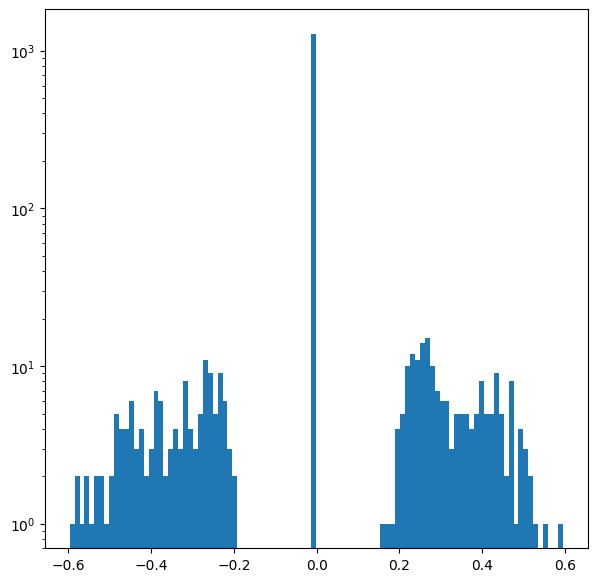

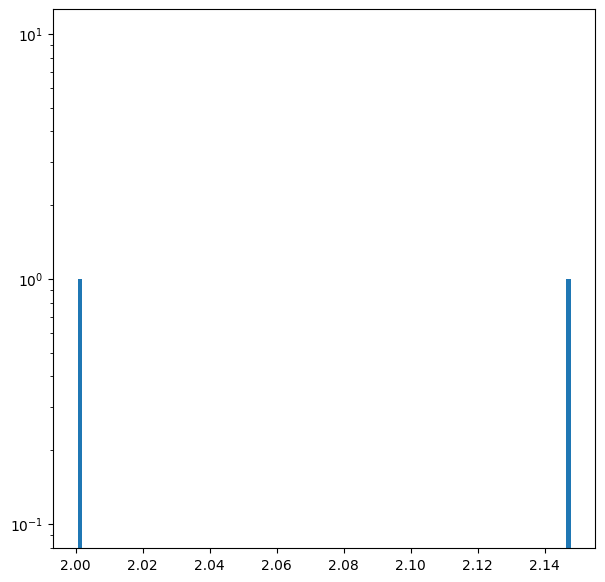

In [15]:
num_layers = len(model.layers)
print(f'Number of layers: {num_layers}')

!mkdir images

for idx in range(num_layers):
    w = model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.savefig(f'images/model-dist-idx{idx}_{START_WINDOW}_{END_WINDOW}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Build the HLS model 

In [16]:
sys.path.append('../utils')
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [17]:
# Load checkpoint 
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

# Re-evalulate 
y_keras = model.predict(X_test)
print(f'Model acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}')
print(model.summary()) 

3125/3125 [==============================] - 4s 1ms/step
Model acc: 0.9573
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 1602      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 1,610
Trainable params: 1,606
Non-trainable params: 4
_________________________________________________________________
None


In [18]:
# Create HLS configuration 
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
HLSConfig['Model']['ReuseFactor'] = 1  # fully parallelized 

HLSConfig['LayerName'] = {}
for layer in ['fc1_input', 'fc1', 'fc1_linear', 'batch_normalization']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc
HLSConfig['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<18,18>'
HLSConfig['LayerName']['fc1']['accum_t'] = 'ap_fixed<18,18>'
# Fc Linear
HLSConfig['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<18,18>'
# Batchnormalization
HLSConfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<16,6>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  fc1
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
    accum_t:         ap_fixed<18,18>
  fc1_linear
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<20,3>
      bias:          ap_fixed<20,3>
      result:        ap_fixed<16,6>
    Trace:           True


In [19]:
OutputDir = f'hls4ml_prjs/{DATASET_DATE}/NN_{START_WINDOW}_{END_WINDOW}_prj'
!rm -rf '{OutputDir}'
!rm -f '{OutputDir}.tar.gz'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
#IOType = 'io_stream'
ClockPeriod = 3.225  # 3.225ns (307.2 MHz)
HLSFig = f'images/model_{START_WINDOW}_{END_WINDOW}.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    project_name='NN'
)

print(f'Creating hls4ml project directory {OutputDir}')
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 2]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory hls4ml_prjs/20240528/NN_100_500_prj
Writing HLS project


Done


## Check performance

In [20]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
y_hls = np.argmax(y_hls, axis=1)

print(f'Keras Acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))*100:.5}%')
print(f'HLS Acc  : {accuracy_score(np.argmax(y_test, axis=1), y_hls)*100:.5}:%')
print(f'CKA      : {accuracy_score(np.argmax(y_keras, axis=1), y_hls)*100:.5}%')

Keras Acc: 95.73%
HLS Acc  : 95.73:%
CKA      : 99.988%


In [21]:
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
np.savetxt(f'{OutputDir}/tb_data/tb_input_features.dat', X_test, fmt='%f', delimiter=' ')
np.savetxt(f'{OutputDir}/tb_data/tb_output_predictions.dat', y_hls, fmt='%f', delimiter=' ')

## Correlation plots (Keras vs HLS)
Let's compare the output of the Qkeras and HLS model. If properly configured, the HLS activations will be aligned with the Qkeras model. 

In [22]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test.astype(np.float32)) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling NN with tracing
Writing HLS project


Done
3125/3125 [==============================] - 4s 1ms/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1', 'batch_normalization'])
Keras Keys: dict_keys(['fc1', 'batch_normalization'])


fc1 		 72.009415
hls/keras min: -19609.0/-19533.84375
hls/keras max: 20355.0/20421.34375
batch_normalization 		 0.03376974
hls/keras min: -6.2041015625/-6.304737091064453
hls/keras max: 6.1943359375/6.352395534515381


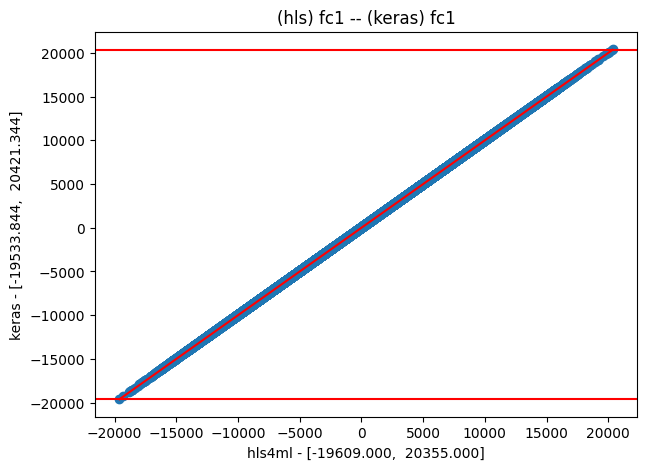

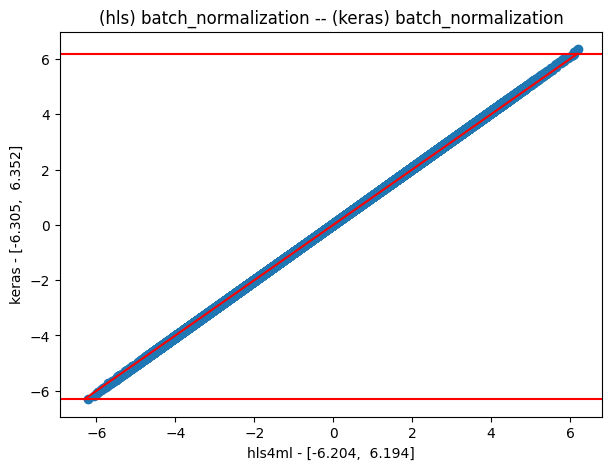

In [23]:
layers = ['fc1', 'batch_normalization']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
    except Exception as e:
        print(e)


## Synthesize 

In [24]:
hls_model.build(
    csim=True,
    synth=False,
    cosim=False,
    export=False,
    vsynth=False,
)

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

## Check the report

In [ ]:
hls4ml.report.read_vivado_report(OutputDir)